# A, B compartment data (pie plot) (A, B, inconsistent, others)

In [1]:
import subprocess
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = 'Arial'
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def stack_percentage_bar(results: pd.DataFrame, cmap_name: str, horizontal: bool = False, annotate: str = 'number') -> tuple:
    """
    Create a stacked percentage bar plot.
    
    Parameters:
    - results: DataFrame where index is the name of each sample and columns are the label of each category.
    - cmap_name: Name of the colormap.
    - horizontal: If True, the bars are horizontal. Default is False.
    - annotate: Specifies the type of annotation ('number' or 'percentage'). Default is 'number'.
    
    Returns:
    - fig, ax: Matplotlib figure and axis objects.
    """
    
    def get_text_color(color):
        r, g, b, _ = color
        if r * g * b < 0.33:
            return 'white'
        elif r * g * b < 0.66:
            return 'grey'
        else:
            return 'black'
    
    def get_annotation_text(results, percentage, annotate):
        if annotate == 'number':
            return [f'{x:d}' for x in results]
        elif annotate == 'percentage':
            return [f'{x/100:.1%}' for x in percentage]
        else:
            raise ValueError(f'Invalid annotate input: {annotate}. Use "number" or "percentage".')

    
    percentage = results.div(results.sum(axis=1), axis=0) * 100
    percentage_cum = percentage.cumsum(axis=1)
    percentage_cum.loc[:, percentage_cum.shape[1] - 1] = 100.0
    category_colors = plt.get_cmap(cmap_name)(np.linspace(0.15, 0.85, results.shape[1]))
    
    if horizontal:
        fig, ax = plt.subplots(figsize=(6.4 * .75, 4.8 * .75))
        ax.invert_yaxis()
        ax.set_xlim(0, 100)
        for i, (category_name, color) in enumerate(zip(results.columns, category_colors)):
            widths = percentage.iloc[:, i]
            starts = percentage_cum.iloc[:, i] - widths
            ax.barh(results.index, widths, left=starts, height=0.618, label=category_name, color=color)
            xcenters = starts + widths / 2
            text_color = get_text_color(color)
            text = get_annotation_text(results.iloc[:, i], percentage.iloc[:, i], annotate)
            for y, (x, c) in enumerate(zip(xcenters, text)):
                ax.text(x, y, c, ha='center', va='center', color=text_color)
        ax.set_xticks(np.arange(0, 120, 20))
        ax.set_xticklabels(np.arange(0, 120, 20))
        ax.set_xlabel('Percentage')
        ax.set_yticks(np.arange(percentage.shape[0]))
        ax.set_yticklabels(percentage.index)
        ax.set_ylabel('Sample')
        ax.legend(ncol=results.shape[1], bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
    else:
        fig, ax = plt.subplots(figsize=(4.8 * .75, 6.4 * .75))
        ax.set_ylim(0, 100)
        for i, (category_name, color) in enumerate(zip(results.columns, category_colors)):
            heights = percentage.iloc[:, i]
            starts = percentage_cum.iloc[:, i] - heights
            ax.bar(results.index, heights, bottom=starts, width=0.618, label=category_name, color=color)
            xcenters = starts + heights / 2
            text_color = get_text_color(color)
            text = get_annotation_text(results.iloc[:, i], percentage.iloc[:, i], annotate)
            for x, (c, y) in enumerate(zip(text, xcenters)):
                ax.text(x, y, c, ha='center', va='center', color=text_color)
        ax.set_xticks(np.arange(results.shape[0]))
        ax.set_xticklabels(percentage.index, rotation=45, ha='right')
        ax.set_xlabel('Sample')
        ax.set_yticks(np.arange(0, 120, 20))
        ax.set_yticklabels(np.arange(0, 120, 20))
        ax.set_ylabel('Percentage')
        ax.legend(bbox_to_anchor=(1, 0), loc='lower left')
    
    return fig, ax


# 5 tissue inconsistent A/B compartment length ratio  
counted by number of 1kb bins

In [3]:
%%bash

cd ~/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/ChromatinStates/Cavalli_Cell2017_ABcompartment_5tissue/Bin1kb_intersect_table

### asign AB compartment to 1kb bins
bin_1kb_fi=/mnt/Storage/home/yanghui/annotations/mm10/Bins/mm10.b1kb.euchr.bed

### A B compartment
for compart in A B;do
    bedtools intersect -c -a $bin_1kb_fi -b <(grep $compart ../AB_compartment_ES_Cavalli_Cell2017.bed) | \
        bedtools intersect -c -a - -b <(grep $compart ../AB_compartment_NPC_Cavalli_Cell2017.bed) | \
        bedtools intersect -c -a - -b <(grep $compart ../AB_compartment_CN_Cavalli_Cell2017.bed) | \
        bedtools intersect -c -a - -b <(grep $compart ../AB_compartment_ncxNPC_Cavalli_Cell2017.bed) | \
        bedtools intersect -c -a - -b <(grep $compart ../AB_compartment_ncxCN_Cavalli_Cell2017.bed) | sort -k1,1 -k2,2n > Bin1kb_5tissue_${compart}.bed
done


### others
bedtools intersect -c -a $bin_1kb_fi -b ../others_compartment_ES_Cavalli_Cell2017.bed | \
    bedtools intersect -c -a - -b ../others_compartment_NPC_Cavalli_Cell2017.bed | \
    bedtools intersect -c -a - -b ../others_compartment_CN_Cavalli_Cell2017.bed | \
    bedtools intersect -c -a - -b ../others_compartment_ncxNPC_Cavalli_Cell2017.bed | \
    bedtools intersect -c -a - -b ../others_compartment_ncxCN_Cavalli_Cell2017.bed | sort -k1,1 -k2,2n > Bin1kb_5tissue_others.bed


In [4]:
intsct_df_binary_dict = {}

In [5]:
os.chdir("/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/ChromatinStates/Cavalli_Cell2017_ABcompartment_5tissue/Bin1kb_intersect_table")
for process in ['Bin1kb'
                ] :
    intsct_df_binary = pd.DataFrame()
    ### A : 4, B : 2, other : 1
    process_l = process
    for i,compart in enumerate(['A', 'B', 'others']) :
        df = pd.read_csv(
            f'{process_l}_5tissue_{compart}.bed',
            sep = "\t",
            header = None,
            usecols = [3,4,5,6,7]
                        )
        if i == 0 :
            intsct_df_binary = df * (2 ** (2-i))
        else :
            intsct_df_binary = intsct_df_binary + df * (2 ** (2-i))

    intsct_df_binary_dict[process] = intsct_df_binary

intsct_df_binary_dict['Bin1kb']

,3,4,5,6,7
0,2,2,2,2,2
1,2,2,2,2,2
2,2,2,2,2,2
3,2,2,2,2,2
4,2,2,2,2,2
...,...,...,...,...,...
2462731,2,2,2,2,2
2462732,2,2,2,2,2
2462733,2,2,2,2,2
2462734,2,2,2,2,2


In [6]:
### 1kb bin are not inconsistent inside each tissue
### in other words, there is no bin on the boundary of A and B compartments
(intsct_df_binary_dict['Bin1kb'].isin([3,5,6,7])).sum()

3    0
4    0
5    0
6    0
7    0
dtype: int64

In [7]:
ABOther_ratio_dict = {}

In [8]:
### A / B length ratio
bin1kb_AB_ratio_df = pd.DataFrame([(intsct_df_binary_dict['Bin1kb'] == 4).sum(axis = 0), 
                                   (intsct_df_binary_dict['Bin1kb'] == 2).sum(axis = 0), 
                                   (intsct_df_binary_dict['Bin1kb'] == 1).sum(axis = 0), ]) ### 4 2 1 sum up is 100%
bin1kb_AB_ratio_df.index = ['A', 'B', 'others']
bin1kb_AB_ratio_df.columns = ['ES', 'NPC', 'CN', 'ncxNPC', 'ncxCN']
bin1kb_AB_ratio_df = bin1kb_AB_ratio_df.T

In [9]:
bin1kb_AB_ratio_df.T.sum()

ES        2462736
NPC       2462736
CN        2462736
ncxNPC    2462736
ncxCN     2462736
dtype: int64

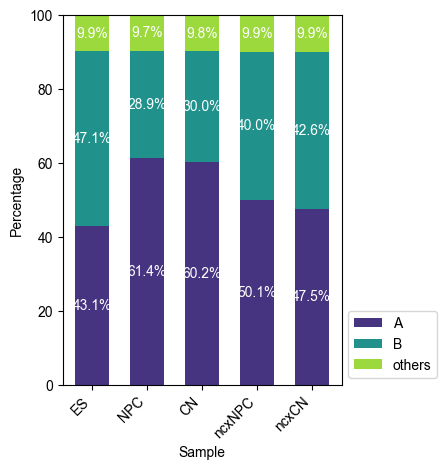

In [10]:
fig, ax = stack_percentage_bar(bin1kb_AB_ratio_df, cmap_name='viridis', annotate='percentage')
plt.show()

In [11]:
ABOther_ratio_dict['Bin1kb'] = bin1kb_AB_ratio_df

In [12]:
# bin1kb_ABinconsistent_df = intsct_df_binary_dict['Bin1kb'].loc[[True if len(row.unique()) > 1 else False for i,row in intsct_df_binary_dict['Bin1kb'].iterrows()]]

In [13]:
# bin1kb_ABinconsistent_df.to_csv(
#     '/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/ChromatinStates/Cavalli_Cell2017_ABcompartment_5tissue/Bin1kb_intersect_table/Bin1kb_ABinconsistent.txt', 
#                                 sep = "\t", header = False, index = True)

bin1kb_ABinconsistent_df = pd.read_csv(
    '/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/ChromatinStates/Cavalli_Cell2017_ABcompartment_5tissue/Bin1kb_intersect_table/Bin1kb_ABinconsistent.txt', 
    sep = "\t", header = None,
)

In [14]:
bin1kb_ABinconsistent_df.index = bin1kb_ABinconsistent_df[0]
bin1kb_ABinconsistent_df.drop(columns = [0], inplace = True)

In [15]:
bin1kb_ABinconsistent_df

,1,2,3,4,5
0,,,,,
4328,1,2,2,2,2
4329,1,2,2,2,2
4330,1,2,2,2,2
4331,1,2,2,2,2
4332,1,2,2,2,2
...,...,...,...,...,...
2462380,2,2,2,1,1
2462381,2,2,2,1,1
2462382,2,2,2,1,1


In [16]:
ABOther_ratio_dict['Bin1kb_inconsistent'] = pd.DataFrame(
    [
        (bin1kb_ABinconsistent_df == 4).sum(axis = 0),
        (bin1kb_ABinconsistent_df == 2).sum(axis = 0),
        (bin1kb_ABinconsistent_df == 1).sum(axis = 0),
    ]
).T
ABOther_ratio_dict['Bin1kb_inconsistent'].index = ['ES', 'NPC', 'CN', 'ncxNPC', 'ncxCN']
ABOther_ratio_dict['Bin1kb_inconsistent'].columns = ['A', 'B', 'others']
ABOther_ratio_dict['Bin1kb_inconsistent']

,A,B,others
ES,194845,563610,98816
NPC,646202,115725,95344
CN,617218,143434,96619
ncxNPC,368187,389390,99694
ncxCN,303423,454161,99687


# CHM in inconsistent A/B compartments ratio

In [17]:
os.chdir("/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/ChromatinStates/Cavalli_Cell2017_ABcompartment_5tissue/CHM_intersect_table")
# intsct_df_binary_dict = {}
for process in ['Universal', 'Universal_complementarySet', 'NonCHMsCpGrich', 
                'EarlyEmbryogenesis_complementarySet', 'EarlyEmbryogenesis_complementarySet_otherCommon',
                'PGCsDevelopment_complementarySet', 'PGCsDevelopment_complementarySet_otherCommon',
                'Spermatogenesis_complementarySet', 'Spermatogenesis_complementarySet_otherCommon',
                'RetinalDevelopment_complementarySet', 'RetinalDevelopment_complementarySet_otherCommon',
                'HeartDevelopment_complementarySet', 'HeartDevelopment_complementarySet_otherCommon',
                'LiverDevelopment_complementarySet', 'LiverDevelopment_complementarySet_otherCommon',
                'EarlyEmbryoSpecific', 
                'PGCSpecific', 
                'SpermSpecific', 
                'RetinalSpecific', 
                'HeartSpecific', 
                'LiverSpecific'
                ] :
    intsct_df_binary = pd.DataFrame()
    ### A : 4, B : 2, other : 1
    process_l = f'{process}CHM' if process != 'NonCHMsCpGrich' else process
    for i,compart in enumerate(['A', 'B', 'others']) :
        df = pd.read_csv(
            f'{process_l}_5tissue_{compart}.bed',
            sep = "\t",
            header = None,
            usecols = [3,4,5,6,7]
                        )
        if i == 0 :
            intsct_df_binary = df * (2 ** (2-i))
        else :
            intsct_df_binary = intsct_df_binary + df * (2 ** (2-i))

    site_df = pd.read_csv(f'{process_l}_5tissue_{compart}.bed', sep = "\t", header = None, usecols = [0,1,2])
    site_df['site'] = site_df[0] + ':' + site_df[1].astype(str) + '-' + site_df[2].astype(str)
    intsct_df_binary_dict[process] = pd.concat([site_df['site'], intsct_df_binary], axis = 1)

intsct_df_binary_dict['Universal']

,site,3,4,5,6,7
0,chr1:4556800-4560500,4,2,2,2,2
1,chr1:4567000-4567800,4,2,2,2,2
2,chr1:5170050-5170800,2,2,2,2,2
3,chr1:5429600-5430850,2,2,2,2,2
4,chr1:5804250-5811550,2,2,2,2,2
...,...,...,...,...,...,...
2672,chr9:121322300-121328400,4,4,4,4,4
2673,chr9:121409000-121413400,4,4,4,4,4
2674,chr9:122402500-122408500,4,4,4,4,4
2675,chr9:123192050-123198200,4,4,4,4,4


In [18]:
### A, B, boundary, inconsistent, others

def inconsistent_condition(row) :
    flag = True
    for x in row :
        if x in [3,5,6] : ### BO, AO, AB (boundary)
            flag = False
            
    if len(row.unique()) == 1 :
        flag = False
            
    return flag


def bed_table_save(intsct_df_binary) :
    bed_table = {}
    bed_table['A'] = intsct_df_binary[(intsct_df_binary == 4).sum(axis = 1) == 5]
    bed_table['B'] = intsct_df_binary[(intsct_df_binary == 2).sum(axis = 1) == 5]
    bed_table['boundary'] = intsct_df_binary[((intsct_df_binary == 3) | (intsct_df_binary == 5) | (intsct_df_binary == 6)).sum(axis = 1) > 0]
    bed_table['inconsistent'] = intsct_df_binary[intsct_df_binary.apply(inconsistent_condition, axis = 1)]
    bed_table['others'] = intsct_df_binary[(intsct_df_binary == 1).sum(axis = 1) == 5]
    return bed_table

size_table_dict = {}
for process in ['Universal', 'Universal_complementarySet', 'NonCHMsCpGrich',
                'EarlyEmbryogenesis_complementarySet', 'EarlyEmbryogenesis_complementarySet_otherCommon',
                'PGCsDevelopment_complementarySet', 'PGCsDevelopment_complementarySet_otherCommon',
                'Spermatogenesis_complementarySet', 'Spermatogenesis_complementarySet_otherCommon',
                'RetinalDevelopment_complementarySet', 'RetinalDevelopment_complementarySet_otherCommon',
                'HeartDevelopment_complementarySet', 'HeartDevelopment_complementarySet_otherCommon',
                'LiverDevelopment_complementarySet', 'LiverDevelopment_complementarySet_otherCommon',
                'EarlyEmbryoSpecific',
                'PGCSpecific',
                'SpermSpecific',
                'RetinalSpecific',
                'HeartSpecific',
                'LiverSpecific'
                ] :
    size_table_dict[process] = bed_table_save(intsct_df_binary_dict[process])

size_table_dict['Universal']['inconsistent']

,site,3,4,5,6,7
0,chr1:4556800-4560500,4,2,2,2,2
1,chr1:4567000-4567800,4,2,2,2,2
2,chr1:5170050-5170800,2,2,2,2,2
3,chr1:5429600-5430850,2,2,2,2,2
4,chr1:5804250-5811550,2,2,2,2,2
...,...,...,...,...,...,...
2672,chr9:121322300-121328400,4,4,4,4,4
2673,chr9:121409000-121413400,4,4,4,4,4
2674,chr9:122402500-122408500,4,4,4,4,4
2675,chr9:123192050-123198200,4,4,4,4,4


In [19]:
os.chdir('/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/ChromatinStates/Cavalli_Cell2017_ABcompartment_5tissue/CHM_intersect_table')
for process in ['Universal', 'Universal_complementarySet', 'NonCHMsCpGrich',
                'EarlyEmbryogenesis_complementarySet', 'EarlyEmbryogenesis_complementarySet_otherCommon',
                'PGCsDevelopment_complementarySet', 'PGCsDevelopment_complementarySet_otherCommon',
                'Spermatogenesis_complementarySet', 'Spermatogenesis_complementarySet_otherCommon',
                'RetinalDevelopment_complementarySet', 'RetinalDevelopment_complementarySet_otherCommon',
                'HeartDevelopment_complementarySet', 'HeartDevelopment_complementarySet_otherCommon',
                'LiverDevelopment_complementarySet', 'LiverDevelopment_complementarySet_otherCommon',
                'EarlyEmbryoSpecific',
                'PGCSpecific',
                'SpermSpecific',
                'RetinalSpecific',
                'HeartSpecific',
                'LiverSpecific'
                ] :
    for compart in ['A', 'B', 'boundary', 'inconsistent', 'others'] :
        df = size_table_dict[process][compart].copy()
        if df.empty :
            continue
        
        df[['chr','siteSE']] = df['site'].str.split(':', expand = True)
        df[['start','end']] = df['siteSE'].str.split('-', expand = True)
        df[['chr','start','end',3,4,5,6,7]].to_csv(f'detailedClass_{process}_5tissue_{compart}.bed', 
                                                 sep = "\t", header = None, index = None, 
                                                 )

read in the detailedClass files

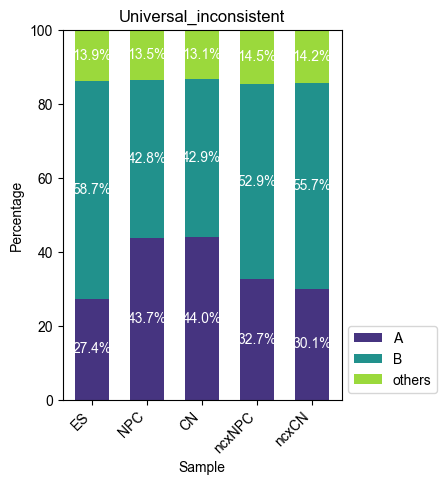

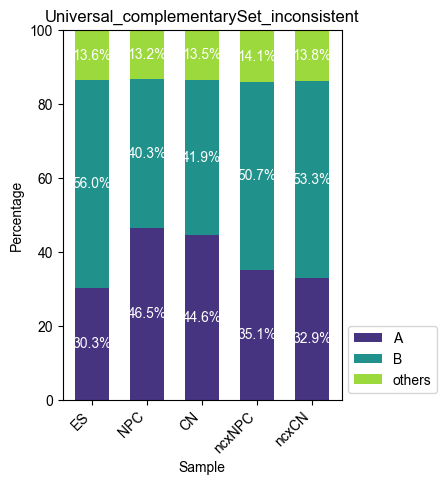

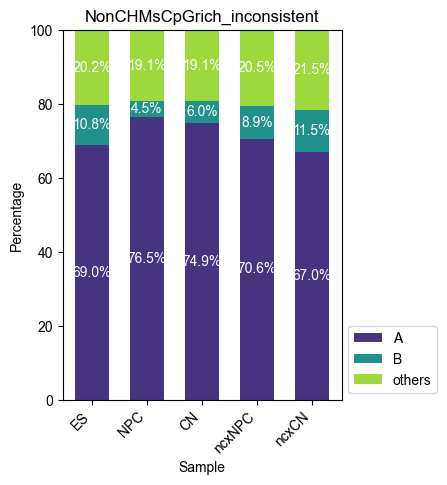

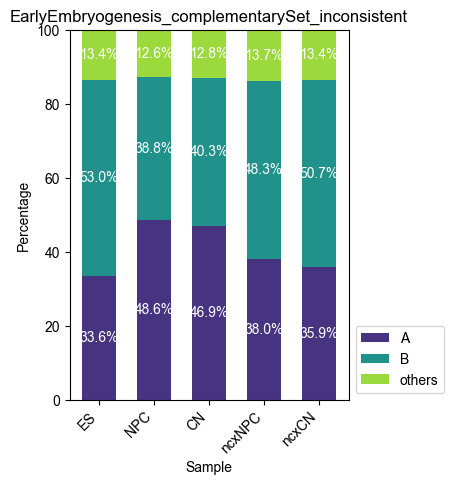

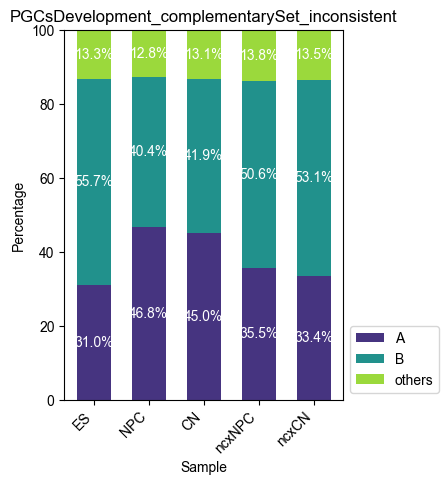

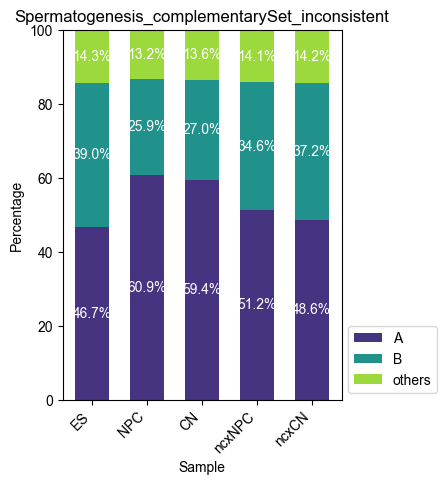

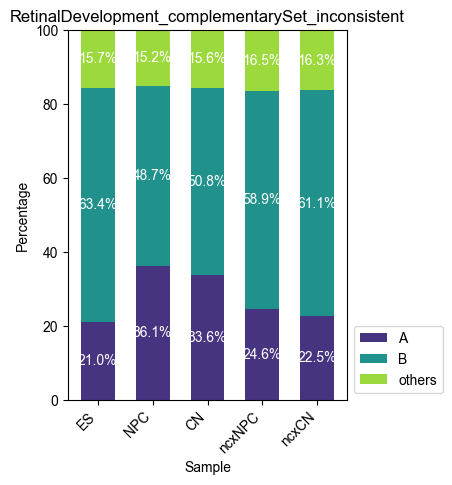

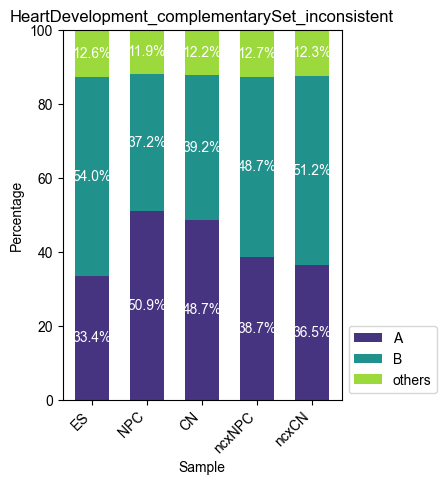

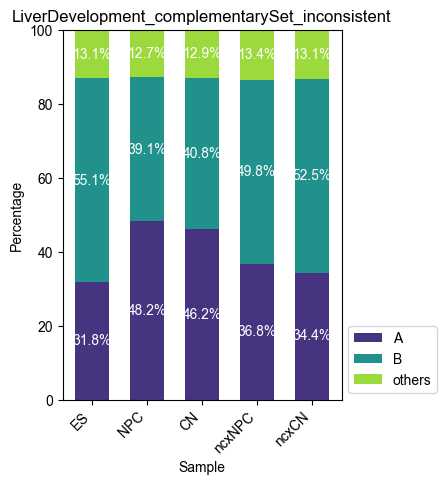

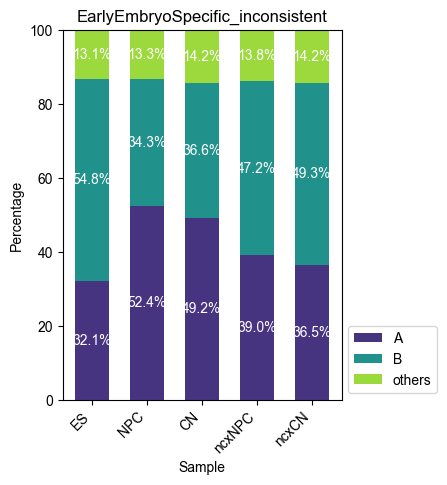

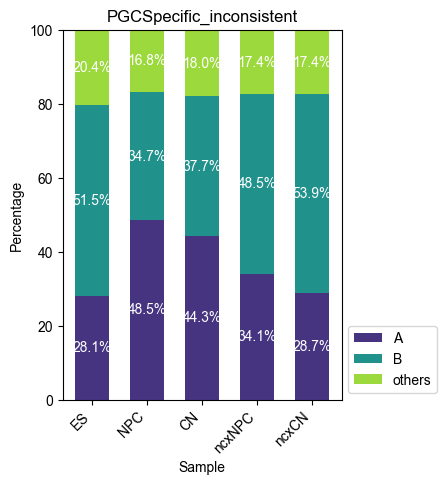

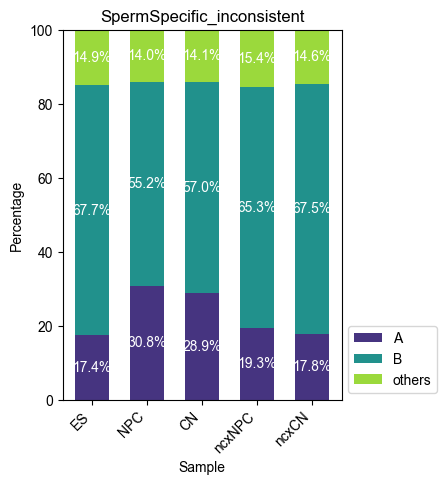

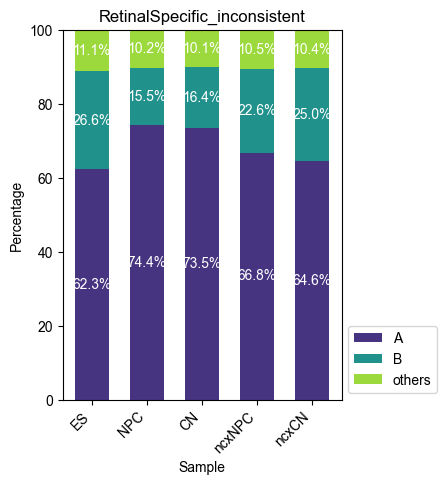

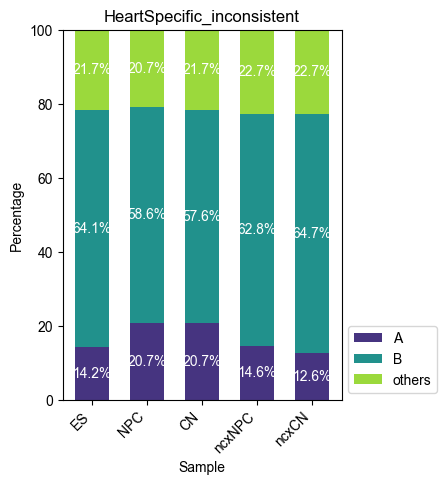

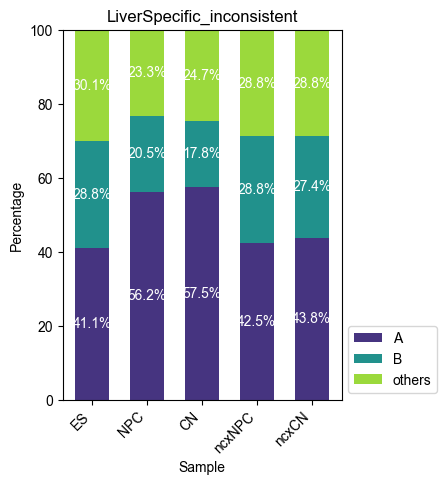

In [20]:
os.chdir('/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/ChromatinStates/Cavalli_Cell2017_ABcompartment_5tissue/CHM_intersect_table')

for process in ['Universal', 'Universal_complementarySet', 'NonCHMsCpGrich',
                'EarlyEmbryogenesis_complementarySet', #'EarlyEmbryogenesis_complementarySet_otherCommon',
                'PGCsDevelopment_complementarySet',    #'PGCsDevelopment_complementarySet_otherCommon',
                'Spermatogenesis_complementarySet',    #'Spermatogenesis_complementarySet_otherCommon',
                'RetinalDevelopment_complementarySet', #'RetinalDevelopment_complementarySet_otherCommon',
                'HeartDevelopment_complementarySet',   #'HeartDevelopment_complementarySet_otherCommon',
                'LiverDevelopment_complementarySet',   #'LiverDevelopment_complementarySet_otherCommon',
                'EarlyEmbryoSpecific',
                'PGCSpecific',
                'SpermSpecific',
                'RetinalSpecific',
                'HeartSpecific',
                'LiverSpecific'
                ] :
    for compart in [
        # 'A', 
        # 'B', 
        # 'boundary', 
        'inconsistent', 
        # 'others'
        ] :
        df = pd.read_csv(f'detailedClass_{process}_5tissue_{compart}.bed', sep = "\t", header = None)
        df.columns = ['chr','start','end', 'ES', 'NPC', 'CN', 'ncxNPC', 'ncxCN']
        ABOthers_df = pd.concat(
            [
                (df.iloc[:,3:] == 4).sum(axis = 0),
                (df.iloc[:,3:] == 2).sum(axis = 0),
                (df.iloc[:,3:] == 1).sum(axis = 0),
            ], axis = 1

        )
        ABOthers_df.columns = ['A', 'B', 'others']
        fig, ax = stack_percentage_bar(ABOthers_df, cmap_name='viridis', annotate='percentage')
        ax.set_title(f'{process}_{compart}')
        plt.show()
        ABOther_ratio_dict[f'{process}_{compart}'] = ABOthers_df
        
        

In [21]:
df_percent_AB = ABOther_ratio_dict['Bin1kb'].div(ABOther_ratio_dict['Bin1kb'].sum(axis = 1), axis = 0) * 100
df_percent_ABinconsistent = ABOther_ratio_dict['Bin1kb_inconsistent'].div(ABOther_ratio_dict['Bin1kb_inconsistent'].sum(axis = 1), axis = 0) * 100

ABOther_ratio_dict_byProcess = pd.DataFrame()

for k in ABOther_ratio_dict.keys() :
    if '_' in k and k != 'Bin1kb_inconsistent' :
        df = ABOther_ratio_dict[k].copy()
        df_percent = df.div(df.sum(axis = 1), axis = 0) * 100
        ### against A/B ratio
        df_vs_AB = np.log10(df_percent.div(df_percent_AB, axis = 0))
        ### against inconsistent A/B ratio
        df_vs_ABinconsistent = np.log10(df_percent.div(df_percent_ABinconsistent, axis = 0))
        
        ### plot
        # fig, ax = plt.subplots(1,2, figsize = (12,4))
        # sns.heatmap(df_vs_AB, cmap = 'coolwarm', center = 0, ax = ax[0])
        # ax[0].set_title(f'{k} vs Bin1kb')
        # sns.heatmap(df_vs_ABinconsistent, cmap = 'coolwarm', center = 0, ax = ax[1])
        # ax[1].set_title(f'{k} vs Bin1kb_inconsistent')
        # plt.show()
        
        
        df_vs_AB_long = df_vs_AB.reset_index().melt(id_vars=['index'], 
                                                    value_vars=['A', 'B', 'others'], 
                                                    var_name='Column', 
                                                    value_name='Value')
        df_vs_AB_long['type'] = 'A/B ratio'
        df_vs_AB_long['process'] = k
        
        df_vs_ABinconsistent_long = df_vs_ABinconsistent.reset_index().melt(id_vars=['index'],
                                                                            value_vars=['A', 'B', 'others'], 
                                                                            var_name='Column', 
                                                                            value_name='Value')
        df_vs_ABinconsistent_long['type'] = 'inconsistent A/B ratio'
        df_vs_ABinconsistent_long['process'] = k
        
        ABOther_ratio_dict_byProcess = pd.concat([ABOther_ratio_dict_byProcess, df_vs_AB_long, df_vs_ABinconsistent_long], axis = 0)
        
        
ABOther_ratio_dict_byProcess

,index,Column,Value,type,process
0,ES,A,-0.196892,A/B ratio,Universal_inconsistent
1,NPC,A,-0.147844,A/B ratio,Universal_inconsistent
2,CN,A,-0.136415,A/B ratio,Universal_inconsistent
3,ncxNPC,A,-0.185790,A/B ratio,Universal_inconsistent
4,ncxCN,A,-0.198276,A/B ratio,Universal_inconsistent
...,...,...,...,...,...
10,ES,others,0.417391,inconsistent A/B ratio,LiverSpecific_inconsistent
11,NPC,others,0.320951,inconsistent A/B ratio,LiverSpecific_inconsistent
12,CN,others,0.340005,inconsistent A/B ratio,LiverSpecific_inconsistent
13,ncxNPC,others,0.393346,inconsistent A/B ratio,LiverSpecific_inconsistent


In [22]:
ABOther_ratio_dict_byProcess['process'].unique()

array(['Universal_inconsistent',
       'Universal_complementarySet_inconsistent',
       'NonCHMsCpGrich_inconsistent',
       'EarlyEmbryogenesis_complementarySet_inconsistent',
       'PGCsDevelopment_complementarySet_inconsistent',
       'Spermatogenesis_complementarySet_inconsistent',
       'RetinalDevelopment_complementarySet_inconsistent',
       'HeartDevelopment_complementarySet_inconsistent',
       'LiverDevelopment_complementarySet_inconsistent',
       'EarlyEmbryoSpecific_inconsistent', 'PGCSpecific_inconsistent',
       'SpermSpecific_inconsistent', 'RetinalSpecific_inconsistent',
       'HeartSpecific_inconsistent', 'LiverSpecific_inconsistent'],
      dtype=object)

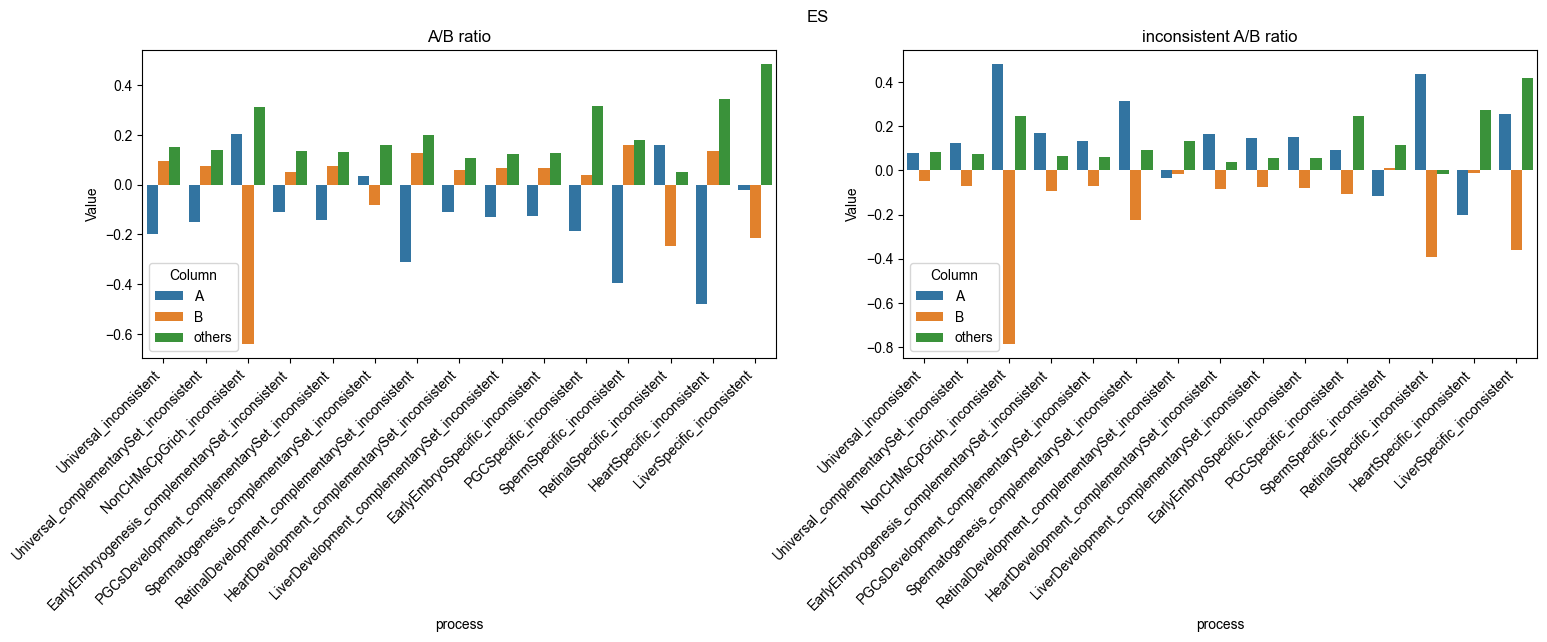

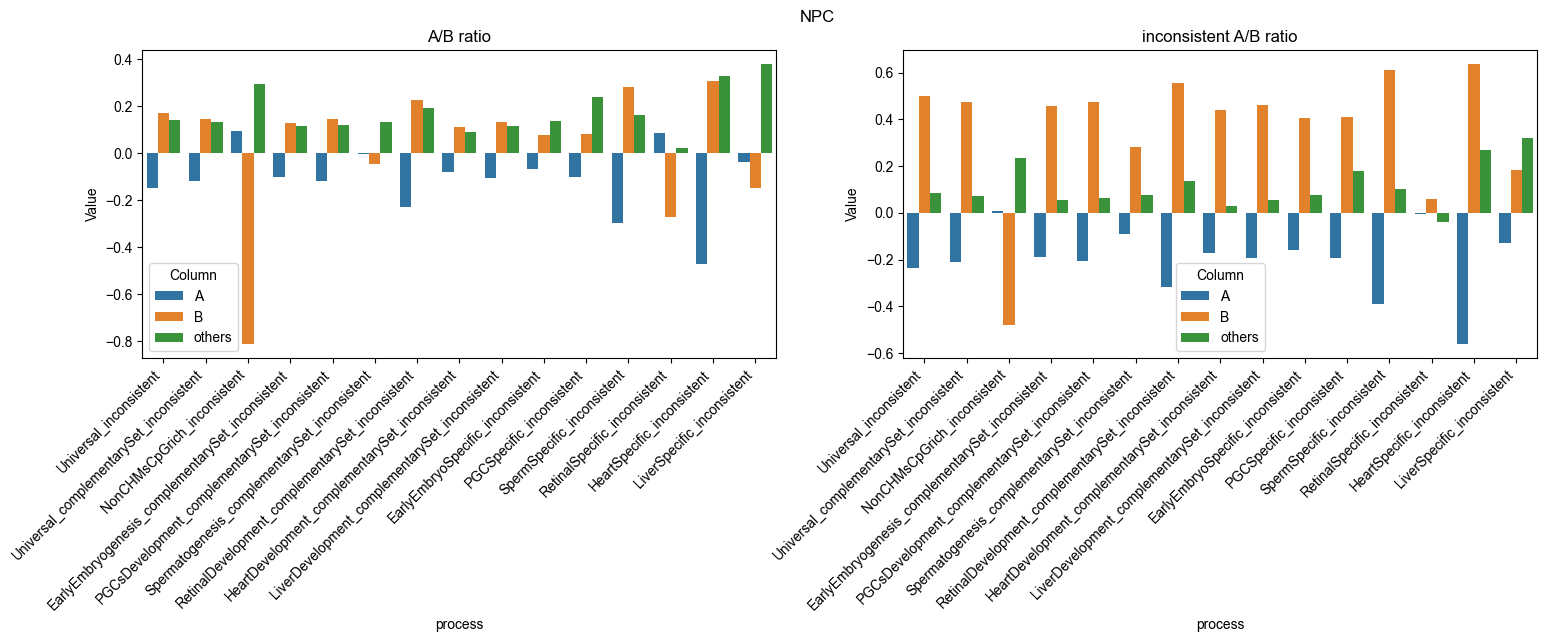

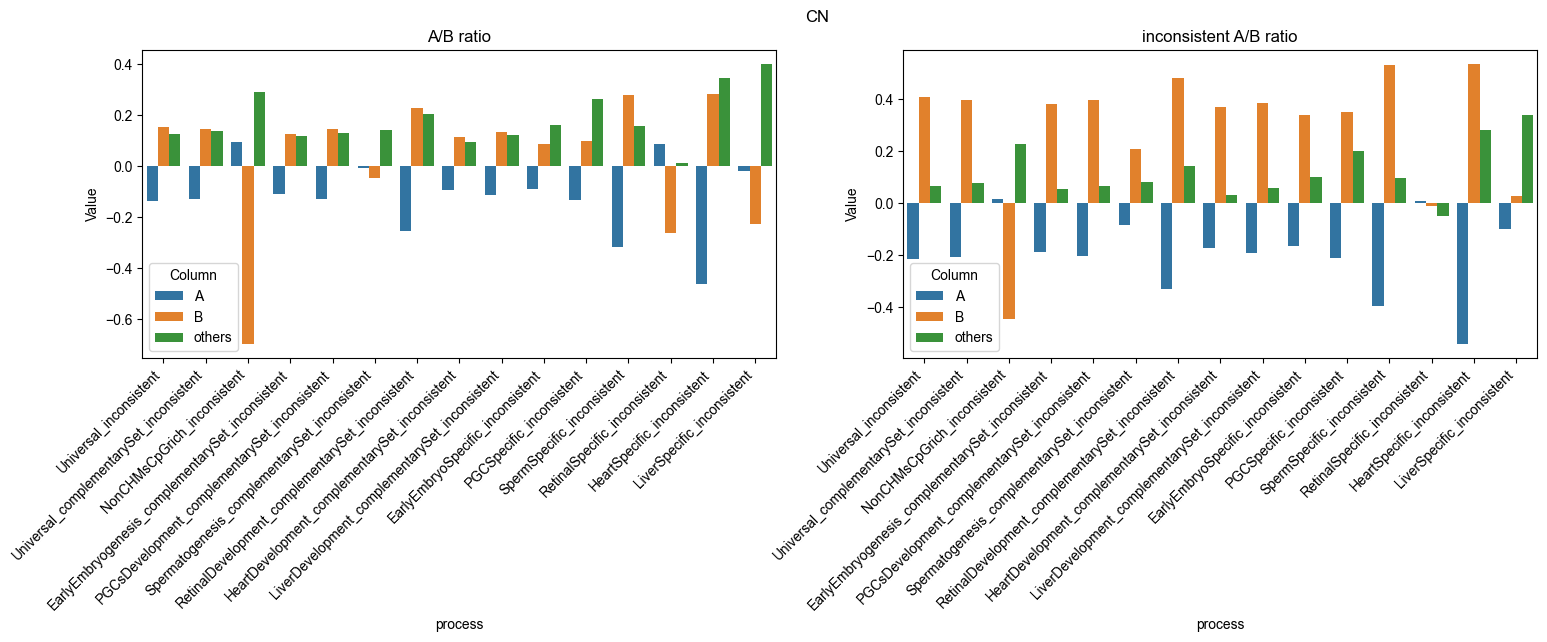

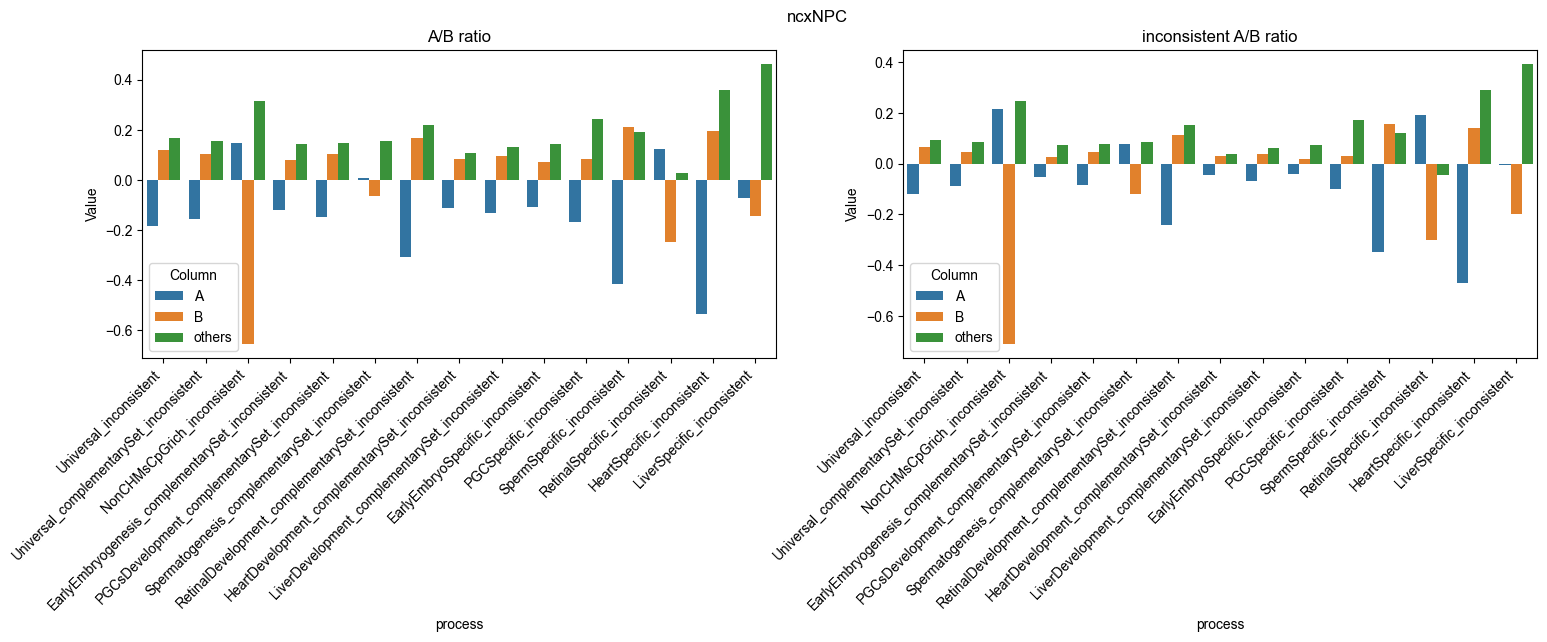

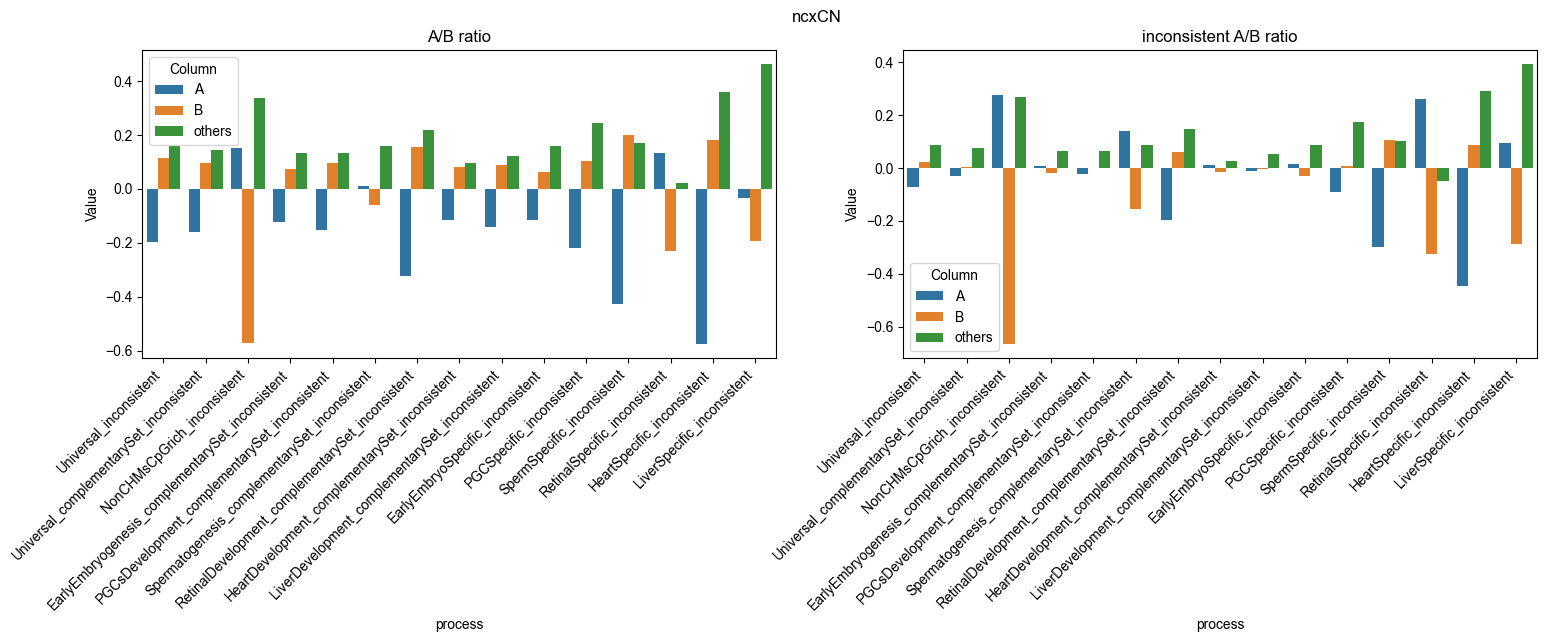

In [23]:
for indeX in ['ES', 'NPC', 'CN', 'ncxNPC', 'ncxCN'] :
    fig, ax = plt.subplots(figsize = (18,4), ncols = 2)
    fig.suptitle(indeX)
    df = ABOther_ratio_dict_byProcess[ABOther_ratio_dict_byProcess['index'] == indeX].copy()
    for type in ['A/B ratio', 'inconsistent A/B ratio'] :
        sns.barplot(
            x = 'process', 
            y = 'Value', 
            data = df[df['type'] == type], 
            hue = 'Column',
            order = [f'{x}_inconsistent' for x in ['Universal', 'Universal_complementarySet', 'NonCHMsCpGrich',
                'EarlyEmbryogenesis_complementarySet', #'EarlyEmbryogenesis_complementarySet_otherCommon',
                'PGCsDevelopment_complementarySet',    #'PGCsDevelopment_complementarySet_otherCommon',
                'Spermatogenesis_complementarySet',    #'Spermatogenesis_complementarySet_otherCommon',
                'RetinalDevelopment_complementarySet', #'RetinalDevelopment_complementarySet_otherCommon',
                'HeartDevelopment_complementarySet',   #'HeartDevelopment_complementarySet_otherCommon',
                'LiverDevelopment_complementarySet',   #'LiverDevelopment_complementarySet_otherCommon',
                'EarlyEmbryoSpecific',
                'PGCSpecific',
                'SpermSpecific',
                'RetinalSpecific',
                'HeartSpecific',
                'LiverSpecific'
                ]],
            ax = ax[0] if type == 'A/B ratio' else ax[1]
            )
        ax[0].set_title('A/B ratio')
        ax[1].set_title('inconsistent A/B ratio')
        ax[0].set_xticks(ax[0].get_xticks())
        ax[1].set_xticks(ax[1].get_xticks())
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation = 45, ha = 'right')
        ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 45, ha = 'right')
    
    plt.show()


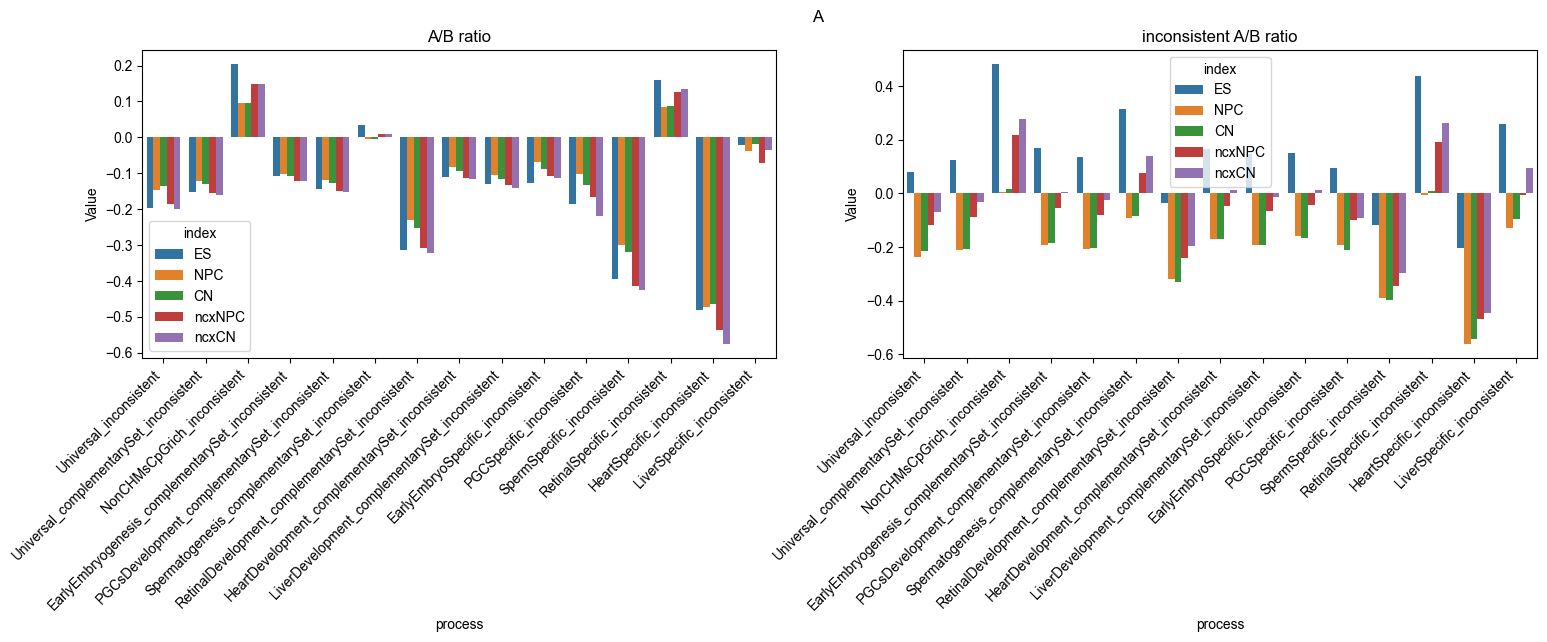

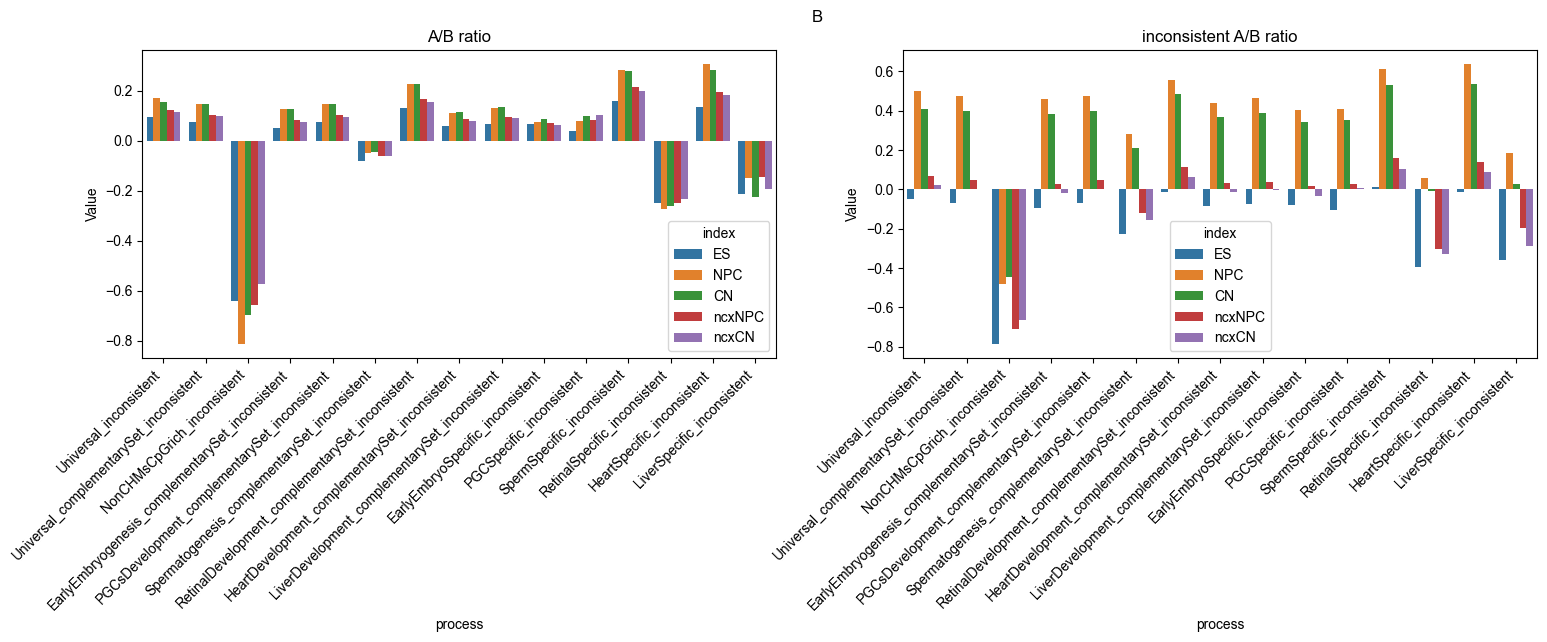

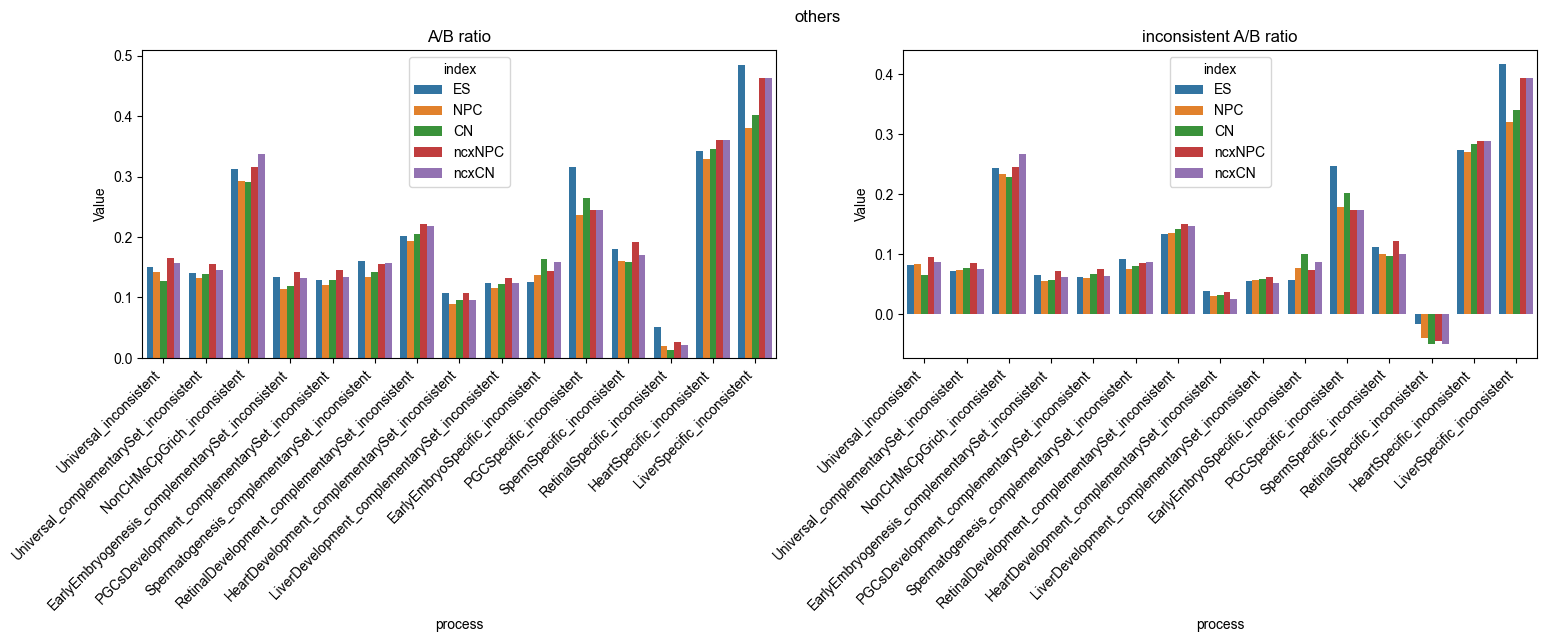

In [24]:
for compart in ['A', 'B', 'others'] :
    fig, ax = plt.subplots(figsize = (18,4), ncols = 2)
    fig.suptitle(compart)
    df = ABOther_ratio_dict_byProcess[ABOther_ratio_dict_byProcess['Column'] == compart].copy()
    for type in ['A/B ratio', 'inconsistent A/B ratio'] :
        sns.barplot(
            x = 'process', 
            y = 'Value', 
            data = df[df['type'] == type], 
            hue = 'index',
            order = [f'{x}_inconsistent' for x in ['Universal', 'Universal_complementarySet', 'NonCHMsCpGrich',
                'EarlyEmbryogenesis_complementarySet', #'EarlyEmbryogenesis_complementarySet_otherCommon',
                'PGCsDevelopment_complementarySet',    #'PGCsDevelopment_complementarySet_otherCommon',
                'Spermatogenesis_complementarySet',    #'Spermatogenesis_complementarySet_otherCommon',
                'RetinalDevelopment_complementarySet', #'RetinalDevelopment_complementarySet_otherCommon',
                'HeartDevelopment_complementarySet',   #'HeartDevelopment_complementarySet_otherCommon',
                'LiverDevelopment_complementarySet',   #'LiverDevelopment_complementarySet_otherCommon',
                'EarlyEmbryoSpecific',
                'PGCSpecific',
                'SpermSpecific',
                'RetinalSpecific',
                'HeartSpecific',
                'LiverSpecific'
                ]],
            ax = ax[0] if type == 'A/B ratio' else ax[1]
            )
        ax[0].set_title('A/B ratio')
        ax[1].set_title('inconsistent A/B ratio')
        ax[0].set_xticks(ax[0].get_xticks())
        ax[1].set_xticks(ax[1].get_xticks())
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation = 45, ha = 'right')
        ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 45, ha = 'right')
    
    plt.show()


In [25]:
ABOther_ratio_dict_byProcess['neuron'] = ABOther_ratio_dict_byProcess['index'].apply(lambda x : 'NPCs / CNs' if 'N' in x else 'ES')

In [26]:
ABOther_ratio_dict_byProcess

,index,Column,Value,type,process,neuron
0,ES,A,-0.196892,A/B ratio,Universal_inconsistent,ES
1,NPC,A,-0.147844,A/B ratio,Universal_inconsistent,NPCs / CNs
2,CN,A,-0.136415,A/B ratio,Universal_inconsistent,NPCs / CNs
3,ncxNPC,A,-0.185790,A/B ratio,Universal_inconsistent,NPCs / CNs
4,ncxCN,A,-0.198276,A/B ratio,Universal_inconsistent,NPCs / CNs
...,...,...,...,...,...,...
10,ES,others,0.417391,inconsistent A/B ratio,LiverSpecific_inconsistent,ES
11,NPC,others,0.320951,inconsistent A/B ratio,LiverSpecific_inconsistent,NPCs / CNs
12,CN,others,0.340005,inconsistent A/B ratio,LiverSpecific_inconsistent,NPCs / CNs
13,ncxNPC,others,0.393346,inconsistent A/B ratio,LiverSpecific_inconsistent,NPCs / CNs


In [31]:
color_dict = {
    'A' : '#bc8cbd', 
    'B' : '#8da9c1'
}

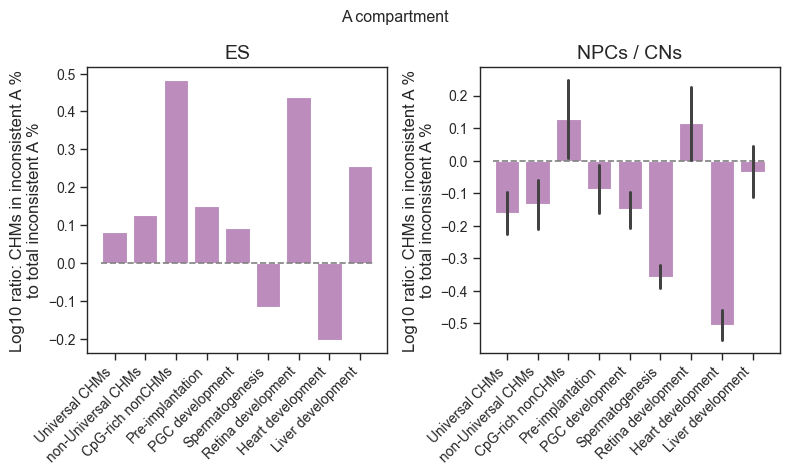

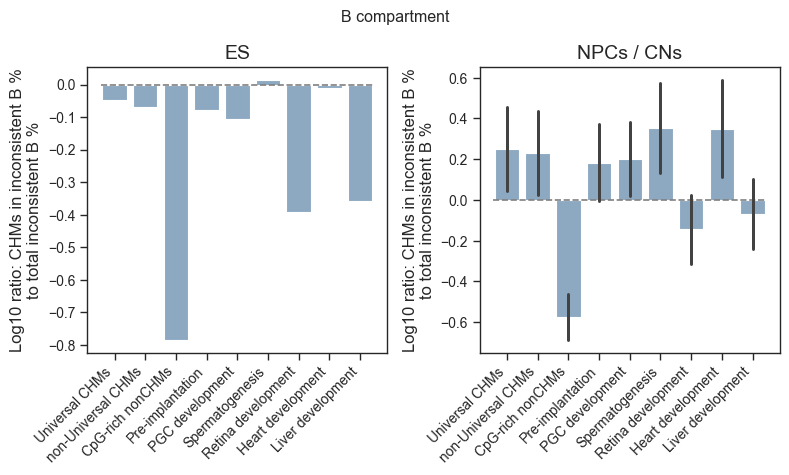

In [47]:
with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 10
                         }):

    for compart in ['A', 'B'] :
        for type in ['inconsistent A/B ratio'] :
            fig, axes = plt.subplots(figsize = (6.4 * 1.25, 4.8), ncols = 2, tight_layout = True)
            fig.suptitle(f'{compart} compartment')
            df = ABOther_ratio_dict_byProcess[ABOther_ratio_dict_byProcess['Column'] == compart].copy()
            for i,if_neuron in enumerate(['ES', 'NPCs / CNs']) :
                df_neuron = df[df['neuron'] == if_neuron]
                subset = df_neuron[df_neuron['type'] == type]
                # Determine colors based on 'Value'
                # bar_colors = ['g' if val >= 0 else 'r' for val in subset['Value']]
                
                ax = axes[i]
                sns.barplot(
                    x='process',
                    y='Value',
                    data=subset,
                    hue='neuron',
                    order = [f'{x}_inconsistent' for x in ['Universal', 'Universal_complementarySet', 'NonCHMsCpGrich',
                        # 'EarlyEmbryogenesis_complementarySet', #'EarlyEmbryogenesis_complementarySet_otherCommon',
                        # 'PGCsDevelopment_complementarySet',    #'PGCsDevelopment_complementarySet_otherCommon',
                        # 'Spermatogenesis_complementarySet',    #'Spermatogenesis_complementarySet_otherCommon',
                        # 'RetinalDevelopment_complementarySet', #'RetinalDevelopment_complementarySet_otherCommon',
                        # 'HeartDevelopment_complementarySet',   #'HeartDevelopment_complementarySet_otherCommon',
                        # 'LiverDevelopment_complementarySet',   #'LiverDevelopment_complementarySet_otherCommon',
                        'EarlyEmbryoSpecific',
                        'PGCSpecific',
                        'SpermSpecific',
                        'RetinalSpecific',
                        'HeartSpecific',
                        'LiverSpecific'
                        ]],
                    ax=ax,
                    palette = [color_dict[compart]],
                    saturation = 1
                    )
                ax.set_title(if_neuron)
                ax.set_xticks(ax.get_xticks())
                ax.set_xticklabels([
                    'Universal CHMs',
                    'non-Universal CHMs',
                    'CpG-rich nonCHMs',
                    'Pre-implantation',
                    'PGC development',
                    'Spermatogenesis',
                    'Retina development',
                    'Heart development',
                    'Liver development',
                    ], 
                                   rotation = 45, ha = 'right')
                ax.legend().set_visible(False)
                ax.hlines(0, -0.45, 8.45, colors = 'grey', linestyles = 'dashed')
                ax.set_xlabel('')
                ax.set_ylabel(f'Log10 ratio: CHMs in inconsistent {compart} %\nto total inconsistent {compart} %')
            fig.savefig(
                f'/mnt/Storage/home/wangyiman/CHMsInOtherContexts/figures/make13_bar_processSpecific_CHMs_inconsistent{compart}_pct_vs_inconsistent{compart}_pct_log10ratio.pdf', 
                transparent = True
                )


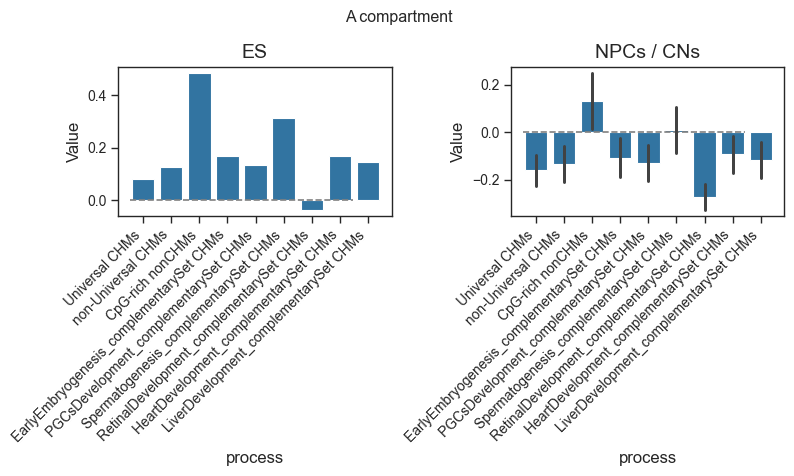

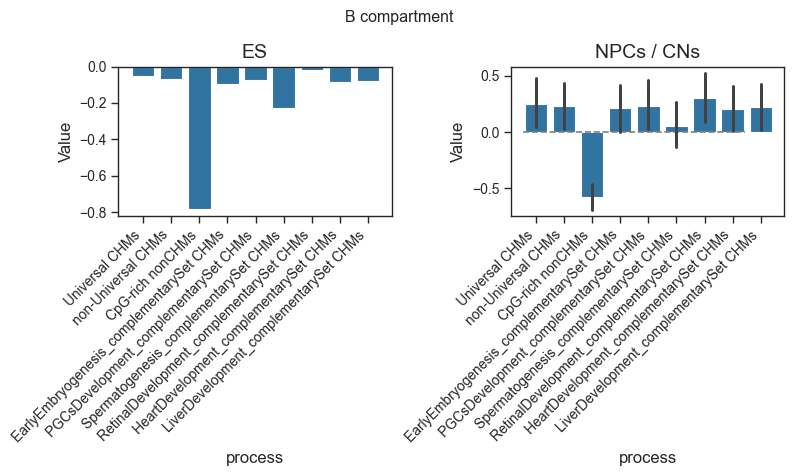

In [28]:
with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 10
                         }):

    for compart in ['A', 'B'] :
        for type in ['inconsistent A/B ratio'] :
            fig, axes = plt.subplots(figsize = (6.4 * 1.25, 4.8), ncols = 2, tight_layout = True)
            fig.suptitle(f'{compart} compartment')
            df = ABOther_ratio_dict_byProcess[ABOther_ratio_dict_byProcess['Column'] == compart].copy()
            for i,if_neuron in enumerate(['ES', 'NPCs / CNs']) :
                df_neuron = df[df['neuron'] == if_neuron]
                subset = df_neuron[df_neuron['type'] == type]
                # Determine colors based on 'Value'
                # bar_colors = ['g' if val >= 0 else 'r' for val in subset['Value']]
                
                ax = axes[i]
                sns.barplot(
                    x='process',
                    y='Value',
                    data=subset,
                    hue='neuron',
                    order = [f'{x}_inconsistent' for x in ['Universal', 'Universal_complementarySet', 'NonCHMsCpGrich',
                        'EarlyEmbryogenesis_complementarySet', #'EarlyEmbryogenesis_complementarySet_otherCommon',
                        'PGCsDevelopment_complementarySet',    #'PGCsDevelopment_complementarySet_otherCommon',
                        'Spermatogenesis_complementarySet',    #'Spermatogenesis_complementarySet_otherCommon',
                        'RetinalDevelopment_complementarySet', #'RetinalDevelopment_complementarySet_otherCommon',
                        'HeartDevelopment_complementarySet',   #'HeartDevelopment_complementarySet_otherCommon',
                        'LiverDevelopment_complementarySet',   #'LiverDevelopment_complementarySet_otherCommon',
                        # 'EarlyEmbryoSpecific',
                        # 'PGCSpecific',
                        # 'SpermSpecific',
                        # 'RetinalSpecific',
                        # 'HeartSpecific',
                        ]],
                    ax=ax,
                    # palette=bar_colors,
                    )
                ax.set_title(if_neuron)
                ax.set_xticks(ax.get_xticks())
                ax.set_xticklabels([f'{x.get_text()[:-13]} CHMs' if not x.get_text().startswith('Universal_complementarySet') and not x.get_text().startswith('Non') else 'non-Universal CHMs' if not x.get_text().startswith('Non') else 'CpG-rich nonCHMs' for x in ax.get_xticklabels()], 
                                   rotation = 45, ha = 'right')
                ax.legend().set_visible(False)
                ax.hlines(0, -0.45, 7.45, colors = 'grey', linestyles = 'dashed')
        
        plt.show()
